In [101]:

from matplotlib.lines import lineStyles
import numpy as np
import os
import json
from tqdm import tqdm
from matplotlib import markers, pyplot as plt
from scipy.fft import rfft, irfft, rfftfreq, fftshift
from scipy.signal import butter, filtfilt, freqz, find_peaks

class ECGAnalysis:
    def __init__(self, file_path, start_end_interval=None):
        self.file_path = file_path
        self.start_end_interval = start_end_interval 
        file_name = os.path.basename(file_path)
        self.title = os.path.splitext(file_name)[0]  # Store file name as title
        self.device, self.user = self._extract_device_user(file_path)
        self.fs = self._compute_sampling_frequency()
        self.low_cutoff = 5
        self.high_cutoff = 40
        self.order = 4
        self.ecg_time, self.ecg_data = self.getData()
        self.filtered_data = None
        self.numerator_polynomials = None
        self.denominator_polynomials = None
        self.computed_frequency = None
        self.frequency_response = None
        self.peaks = None
        self.avg_bpm = None
        self.peaks_time = None
        self.beat_intervals = None
        self.heart_rate_variability = None
        self.interpolated_timecourse = None
        self.frequency_ratio = None
        self.pr_intervals = []
        self.qrs_intervals = []
        self.qt_intervals = []
        self.p_peaks = []
        self.q_peaks = []
        self.s_peaks = []
        self.t_peaks = []
        
        if start_end_interval is not None:
            print(f"Start time: {start_end_interval[0]}, End time: {start_end_interval[1]}")  # Debug print statement
        
        print(f"ECG data {self.file_path} loaded successfully.")  
        
    @staticmethod
    def _extract_device_user(file_path):
        # Extract device and user information from file path
        parts = file_path.split(os.sep)
        device = int(parts[-3].split('_')[-1])
        user = int(parts[-2].split('_')[-1].split('.')[0])
        return device, user


    @classmethod
    def load_ecg_data(cls, root_dir, device, user, days=None, start_end_interval=None):
        """Load ECG data from specified device, user, and days."""
        ecg_objects = []

        device_path = os.path.join(root_dir, f'device_{device:02}')
        if not os.path.exists(device_path):
            raise ValueError(f"Device {device} does not exist.")

        user_path = os.path.join(device_path, f'user_{user:03}')
        if not os.path.exists(user_path):
            raise ValueError(f"User {user} does not exist for device {device}.")

        if days is None:
            files = [file_name for file_name in os.listdir(user_path) if file_name.startswith('ecg') and file_name.endswith('.csv')]
        else:
            if days == 'all':
                days = range(1, 31)
            files = [f'ecg_day_{day:02}.csv' for day in days]

        # Use tqdm to display progress bar
        for file_name in tqdm(files, desc='Loading ECG data'):
            file_path = os.path.join(user_path, file_name)
            ecg_objects.append(cls(file_path, start_end_interval=start_end_interval))

        return ecg_objects
    
    def _compute_sampling_frequency(self):
        data = np.loadtxt(self.file_path, delimiter=',', skiprows=1)
        time = data[:, 0]
        fs = 1 / (time[1] - time[0])
        return fs
    
    def getData(self):
        data = np.loadtxt(self.file_path, delimiter=',', skiprows=1)
        start_time = self.start_end_interval[0] if self.start_end_interval is not None else 0
        end_time = self.start_end_interval[1] if self.start_end_interval is not None else len(data)
        data = data[int(start_time * self.fs):int(end_time * self.fs)]
        time = data[:, 0]
        data = data[:, 1]
        return time, data

    def creat_filterd_data(self):
        nyquist = 0.5 * self.fs
        low = self.low_cutoff / nyquist
        high = self.high_cutoff / nyquist
        self.numerator_polynomials, self.denominator_polynomials = butter(self.order, [low, high], btype='bandpass')
        self.filtered_data = filtfilt(self.numerator_polynomials, self.denominator_polynomials, self.ecg_data)
        print(f"Filtered ECG data created successfully.")
    
    def plot_comparison(self):

        plt.figure(2, figsize=(20, 8))
        plt.ylabel("ecg_signal (uV)")
        plt.xlabel("Time (s)")
        plt.plot(self.ecg_time, self.ecg_data, "r", linewidth=1, label="Raw ECG signal")
        plt.legend(loc="lower left")
        plt.plot(self.ecg_time, self.filtered_data, linewidth=1, label="Filtered ECG signal (%g Hz) using sosfilt" % self.fs)
        # plt.xticks(np.arange(self.start_end_interval[0], self.start_end_interval[1], step=1))
        plt.grid(True)
        plt.axis("tight")
        plt.legend(loc="upper right")
        plt.title("Filtered ECG signal")
        plt.show()
        print(f"Filtered ECG signal plotted successfully.")
        
    def compute_heart_rate(self, plot=False):
        threshold = 0
        height = 0.22
        distance = 65
        
        peaks, _ = find_peaks(self.filtered_data, height=height, threshold=threshold, distance=distance)
        peaks_time = self.ecg_time[peaks]
        peak_intervals = np.diff(peaks_time)
        avg_bpm = 60 / np.mean(peak_intervals) if len(peak_intervals) > 0 else 0
        print(f"Average heart rate: {avg_bpm:.2f} bpm")
        
        self.peaks = peaks
        self.avg_bpm = avg_bpm
        self.peaks_time = peaks_time
        
        if plot:
            self.plot_heart_beats(peaks, peaks_time, avg_bpm)
        
        return peaks, avg_bpm
    
    def plot_heart_beats(self, peaks, peaks_time, avg_bpm):
        plt.figure(figsize=(20, 10))
        plt.plot(self.ecg_time, self.filtered_data, linewidth=1, label="Filtered ECG signal")
        plt.plot(peaks_time, self.filtered_data[peaks], 'o', label="Heart Beats", markersize=5, markerfacecolor='red', markeredgecolor='black')
        plt.plot(self.ecg_time, self.ecg_data, linewidth=1, color='red', linestyle='--', label="Raw ECG signal")
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.title(f"Heart Beats Detection (Avg BPM: {avg_bpm:.2f})")
        plt.xlabel("Time (ms)")
        plt.ylabel("ECG Signal (uV)")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        
    def detect_wave_peaks(self):
        # Use self.peaks as R peaks
        r_peaks = self.peaks
        
        # Search ranges around R peaks for other waves
        p_search_range = int(self.fs * 1)  # Adjust as needed
        q_search_range = int(self.fs * 0.5)  # Adjust as needed
        s_search_range = int(self.fs * 0.5)  # Adjust as needed
        t_search_range = int(self.fs * 0.5)  # Adjust as needed
        
       # Find P peaks
        self.p_peaks = []
        for r in r_peaks:
            p_peak, _ = find_peaks(-self.filtered_data[max(0, r - p_search_range):r], height=0)
            if len(p_peak) > 0:
                self.p_peaks.append(p_peak[-1] + max(0, r - p_search_range))
        
        # Find Q peaks (negative peak before R)
        self.q_peaks = []
        for r in r_peaks:
            q_peak, _ = find_peaks(-self.filtered_data[max(0, r - q_search_range):r], height=0)
            if len(q_peak) > 0:
                self.q_peaks.append(q_peak[-1] + max(0, r - q_search_range))
        
        # Find S peaks (negative peak after R)
        self.s_peaks = []
        for r in r_peaks:
            s_peak, _ = find_peaks(-self.filtered_data[r:min(len(self.filtered_data), r + s_search_range)], height=0)
            if len(s_peak) > 0:
                self.s_peaks.append(s_peak[0] + r)
        
        # Find T peaks (positive peak after R)
        self.t_peaks = []
        for r in r_peaks:
            t_peak, _ = find_peaks(self.filtered_data[r:min(len(self.filtered_data), r + t_search_range)], height=0)
            if len(t_peak) > 0:
                self.t_peaks.append(t_peak[0] + r)
        
        return self.p_peaks, self.q_peaks, self.s_peaks, self.t_peaks

    def compute_intervals(self):
        p_peaks, q_peaks, s_peaks, t_peaks = self.detect_wave_peaks()
        
        # Compute PR intervals
        for p in p_peaks:
            r_after_p = [r for r in self.peaks if r > p]
            if len(r_after_p) > 0:
                pr_interval = (r_after_p[0] - p) / self.fs
                self.pr_intervals.append(pr_interval)
        
        # Compute QRS intervals
        for r in self.peaks:
            q_before_r = [q for q in q_peaks if q < r]
            s_after_r = [s for s in s_peaks if s > r]
            if len(q_before_r) > 0 and len(s_after_r) > 0:
                qrs_interval = (s_after_r[0] - q_before_r[-1]) / self.fs
                self.qrs_intervals.append(qrs_interval)
        
        # Compute QT intervals
        for t in t_peaks:
            r_before_t = [r for r in self.peaks if r < t]
            if len(r_before_t) > 0:
                qt_interval = (t - r_before_t[-1]) / self.fs
                self.qt_intervals.append(qt_interval)
                
        # print(f"PR intervals: {self.pr_intervals}")
        # print(f"QRS intervals: {self.qrs_intervals}")
        # print(f"QT intervals: {self.qt_intervals}")
        
        return self.pr_intervals, self.qrs_intervals, self.qt_intervals


    def plot_intervals(self):
        plt.figure(figsize=(20, 8))
        plt.plot(self.ecg_time, self.filtered_data, linewidth=1,  label="Filtered ECG signal")
        plt.plot(self.ecg_time, self.ecg_data, color='red', linestyle='--', linewidth=1, label="Raw ECG signal")
        
        p_peaks, q_peaks, s_peaks, t_peaks = self.detect_wave_peaks()
        
        # Plot R peaks with circles
        plt.scatter(self.ecg_time[self.peaks], self.filtered_data[self.peaks], marker='o', color='r', label="R peaks")
        
        # Plot P peaks with downward-pointing triangles
        if len(p_peaks) > 0:
            plt.scatter(self.ecg_time[p_peaks], self.filtered_data[p_peaks], marker='v', color='g', label="P peaks")
        
        # Plot Q peaks with x markers
        if len(q_peaks) > 0:
            plt.scatter(self.ecg_time[q_peaks], self.filtered_data[q_peaks], marker='x', color='b', label="Q peaks")
        
        # Plot S peaks with squares
        if len(s_peaks) > 0:
            plt.scatter(self.ecg_time[s_peaks], self.filtered_data[s_peaks], marker='s', color='m', label="S peaks")
        
        # Plot T peaks with asterisks
        if len(t_peaks) > 0:
            plt.scatter(self.ecg_time[t_peaks], self.filtered_data[t_peaks], marker='*', color='y', label="T peaks")
        
        plt.title("ECG Waveform with Detected Peaks")
        plt.xlabel("Time (ms)")
        plt.ylabel("ECG Signal (uV)")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def store_intervals_as_json(self, output_file):
        
        self.pr_intervals, self.qrs_intervals, self.qt_intervals = self.compute_intervals()
        
        intervals_data = {
            'title': self.title,
            'device': self.device,
            'user': self.user,
            'pr_intervals': self.pr_intervals,
            'qrs_intervals': self.qrs_intervals,
            'qt_intervals': self.qt_intervals
        }
        with open(output_file, 'w') as f:
            json.dump(intervals_data, f, indent=4)
        print(f"PR, QRS, QT Interval data saved to {output_file}")



In [102]:
root_directory = 'ECG_data_new'
device_number = 1
user_number = 1
start_end_interval = [5, 10]
output_file = 'intervals.json'



In [103]:
# Load the ECG data
ecg_objects = ECGAnalysis.load_ecg_data(root_dir=root_directory, device=device_number, user=user_number, start_end_interval=start_end_interval)
print(f"Number of ECG records loaded: {len(ecg_objects)}")



Loading ECG data:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s]

Start time: 5, End time: 10
ECG data ECG_data_new/device_01/user_001/ecg_22copy.csv loaded successfully.


Loading ECG data: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

Start time: 5, End time: 10
ECG data ECG_data_new/device_01/user_001/ecg_22Feb2022_1500hour.csv loaded successfully.
Number of ECG records loaded: 2


## Noise Filtering

Filtered ECG data created successfully.


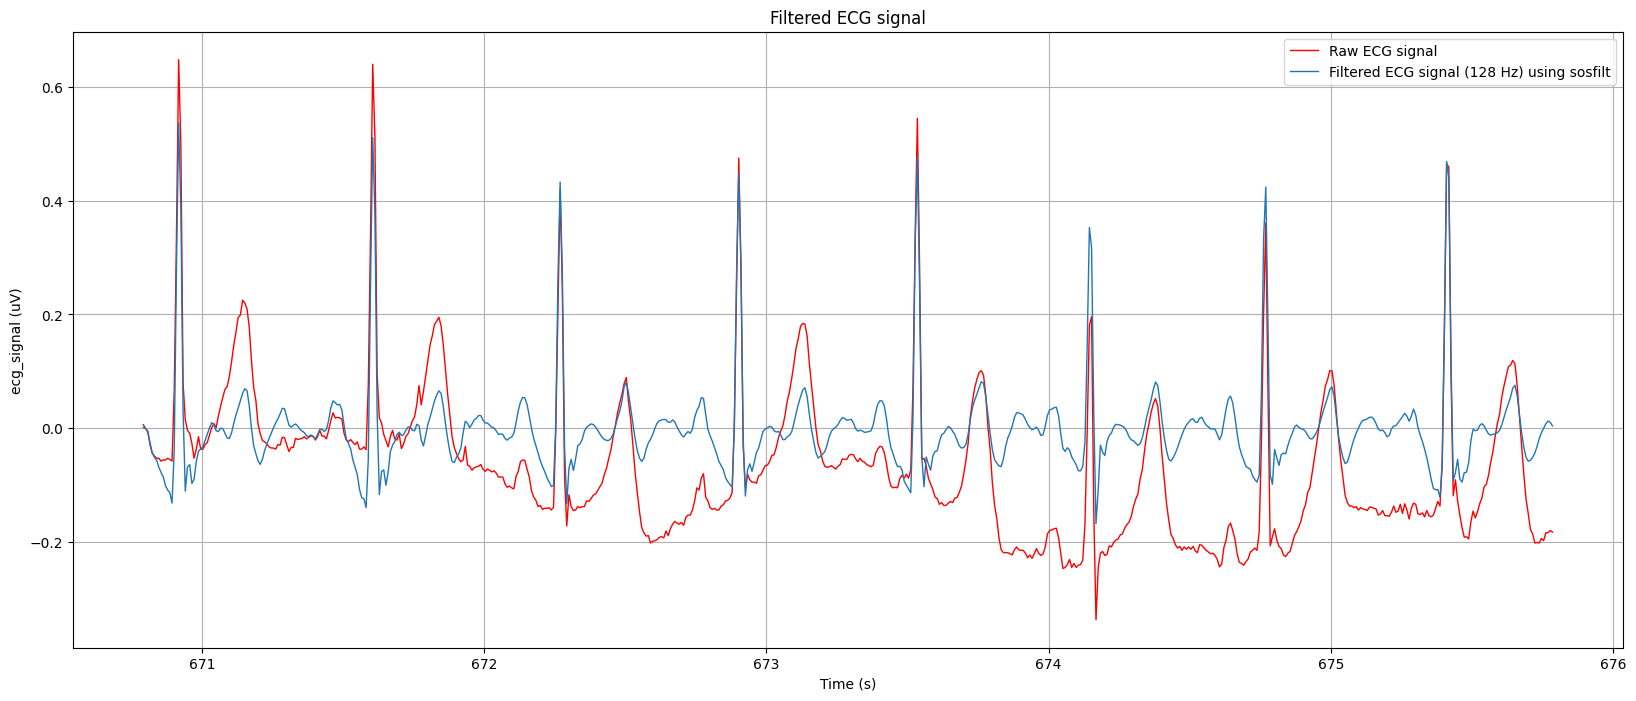

Filtered ECG signal plotted successfully.


In [104]:
ecg = ecg_objects[0]
ecg.creat_filterd_data()
ecg.plot_comparison()


Average heart rate: 93.50 bpm


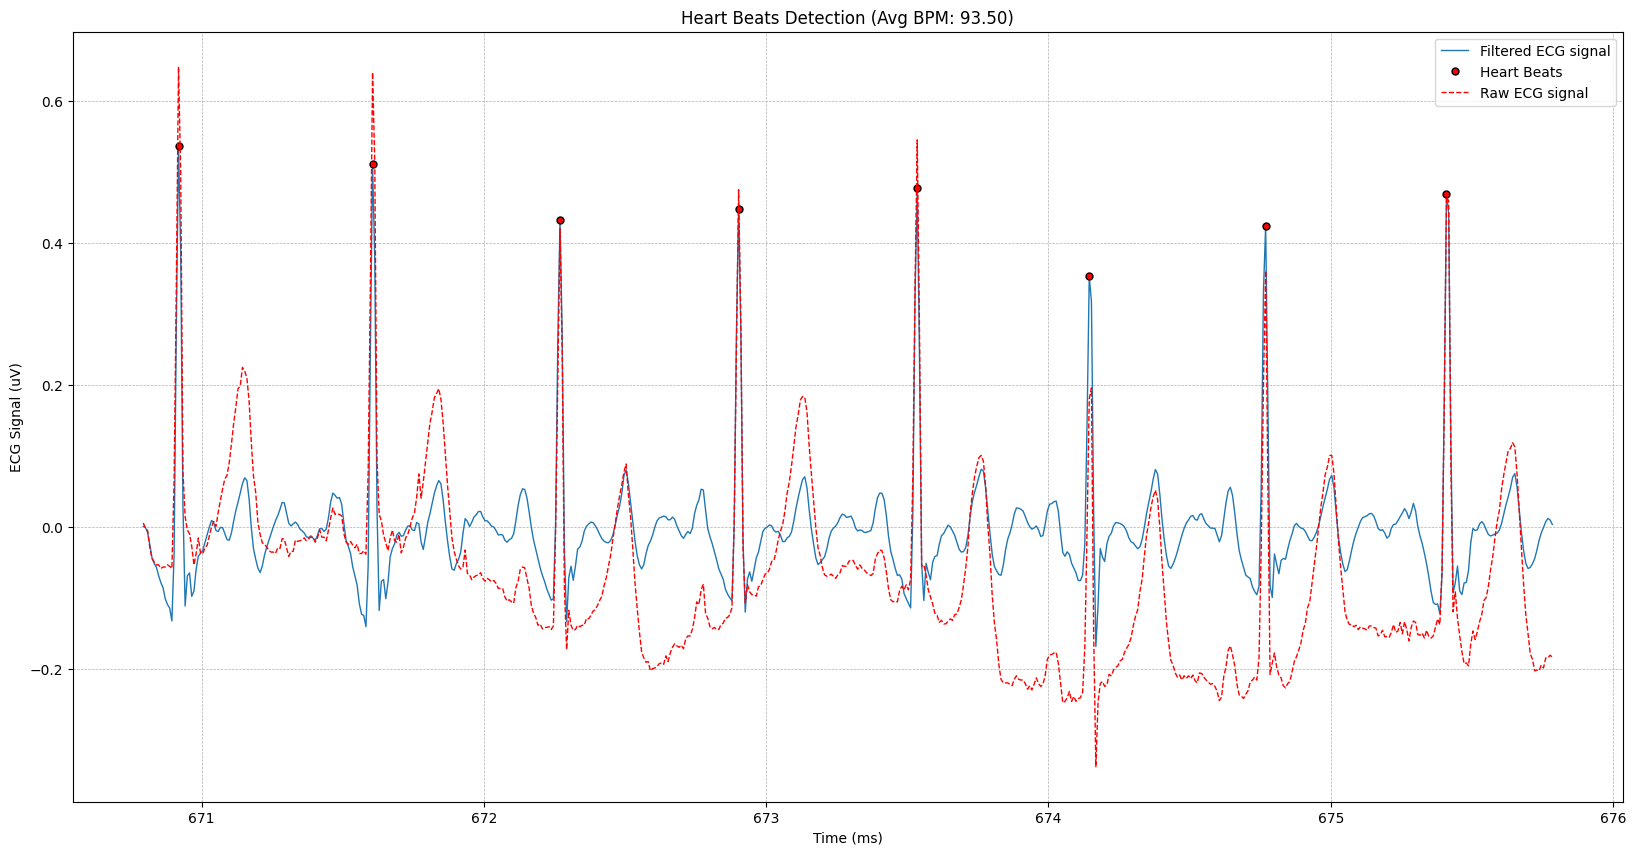

In [105]:
peaks, avg_bpm = ecg.compute_heart_rate(plot=True)
# print(f"Detected peaks: {peaks}")
# print(f"Average heart rate: {avg_bpm:.2f} BPM")


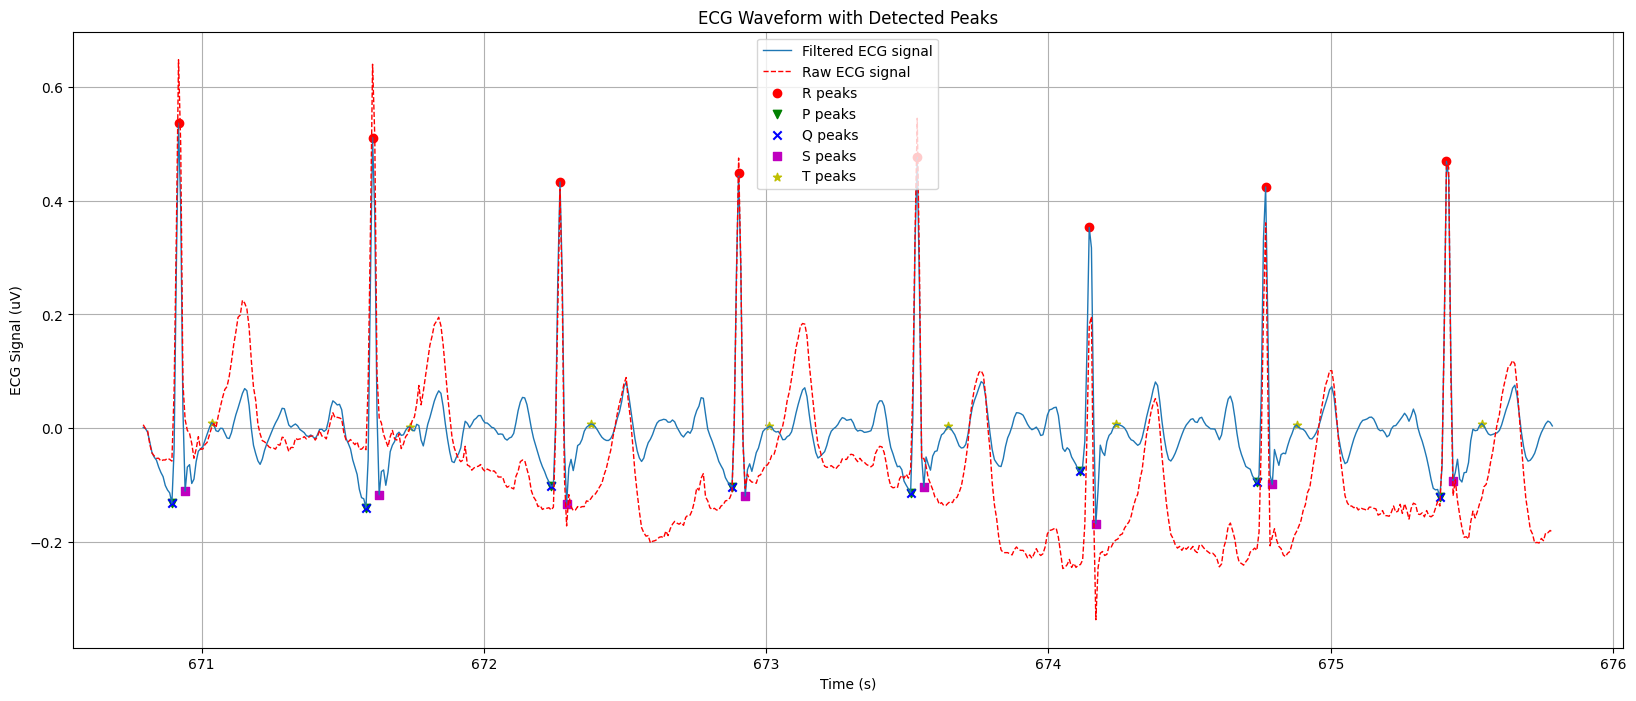

In [106]:
ecg.plot_intervals()

In [73]:
output_file = 'intervals.json'
ecg.store_intervals_as_json(output_file)

PR, QRS, QT Interval data saved to intervals.json
